In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import json
import string
import re
import seaborn as sns 
    
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

import nltk
from nltk.tokenize import RegexpTokenizer

from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize

In [2]:
data = pd.read_json("tweets.json")

In [3]:
# Extracting keys of each tweets from json file
print((data['tweets'][0]).keys())
print(" ")
print("Printing one sample tweet as a dict\n")
print((data['tweets'][0]))

dict_keys(['text', 'hashtags', 'user', 'user_loc'])
 
Printing one sample tweet as a dict

{'text': 'RT @steve_vladeck: There’s no excuse for how hard it is to vote.\n\nThere’s even less of an excuse for how much harder it is in some jurisdic…', 'hashtags': [], 'user': 'wallinwe', 'user_loc': 'Denver, Colorado'}


In [4]:
# Creating an empty list for text of tweets
tweets_txt = []
for i in range(len(data['tweets'])):
    tweets_txt.append((data['tweets'][i])['text'])

In [5]:
df = pd.DataFrame()

In [6]:
df['tweet'] = tweets_txt

In [7]:
df.head()

,tweet
0,RT @steve_vladeck: There’s no excuse for how h...
1,RT @karan1976U: W..Vote harder\n#KCA\n#VoteTay...
2,RT @JulieSmithM: I don’t want to hear anything...
3,RT @Holly_WV: ‼️LMAO‼️\nIf you haven’t seen th...
4,RT @nhannahjones: Forcing people to wait in li...


In [8]:
df['is_retweet'] = df['tweet'].apply(lambda x: x[:2]=='RT')
total_retwet = df['is_retweet'].sum()  # number of retweets
print("Total retweets are",total_retwet)

Total retweets are 10543


In [9]:
df.head()

,tweet,is_retweet
0,RT @steve_vladeck: There’s no excuse for how h...,True
1,RT @karan1976U: W..Vote harder\n#KCA\n#VoteTay...,True
2,RT @JulieSmithM: I don’t want to hear anything...,True
3,RT @Holly_WV: ‼️LMAO‼️\nIf you haven’t seen th...,True
4,RT @nhannahjones: Forcing people to wait in li...,True


In [10]:
df.to_csv('temp.csv')

In [11]:
df = pd.read_csv('temp.csv')

In [12]:
print("Unique tweets are",df.loc[df['is_retweet']].tweet.unique().size)

Unique tweets are 3661


In [13]:
df.applymap(lambda x: isinstance(x, list)).all()

Unnamed: 0    False
tweet         False
is_retweet    False
dtype: bool

In [14]:
df.groupby(['tweet']).size().reset_index(name='counts')\
  .sort_values('counts', ascending=False).head(10)

,tweet,counts
5549,RT @realDonaldTrump: This is a direct &amp; da...,249
5806,RT @traceyecorder: Bernie says that our incarc...,174
3588,RT @MsJuneDiane: Stop telling your daughters t...,115
3982,RT @ScottTParkinson: Possibly the biggest mist...,110
3344,RT @LacyJohnsonMN: Ilhan Omar is upset Bernie ...,96
2375,RT @AndrewDesiderio: NEW: Ron Johnson says he’...,84
3184,RT @Jim_Jordan: Today's Left:\n\nFirst Schumer...,84
4075,RT @Susan_Hennessey: Of course he will. The qu...,83
3869,RT @RepDougCollins: Less than one month after ...,70
2714,RT @ConnieSchultz: You can tell me and you can...,64


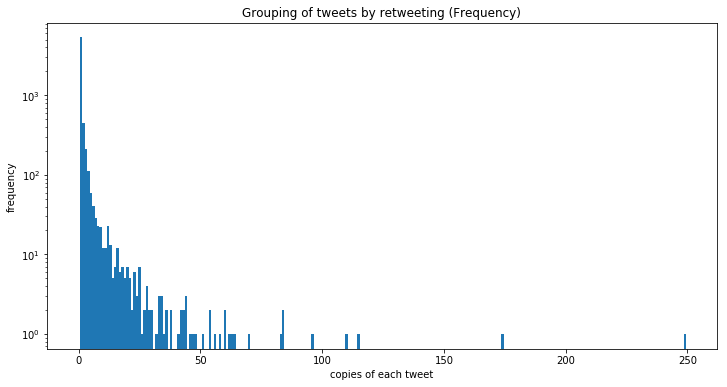

In [15]:
# number of times each tweet appears
counts = df.groupby(['tweet']).size()\
           .reset_index(name='counts')\
           .counts

# define bins for histogram
my_bins = np.arange(0,counts.max()+2, 1)-0.5

# plot histogram of tweet counts
plt.figure(figsize=(12,6))
plt.title("Grouping of tweets by retweeting (Frequency)")
plt.hist(counts, bins = my_bins)
plt.xlabels = np.arange(1,counts.max()+1, 1)
plt.xlabel('copies of each tweet')
plt.ylabel('frequency')
plt.yscale('log', nonposy='clip')
plt.show()

In [16]:
def find_retweeted(tweet):
    '''This function will extract the twitter handles of retweed people'''
    return re.findall('(?<=RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

def find_mentioned(tweet):
    '''This function will extract the twitter handles of people mentioned in the tweet'''
    return re.findall('(?<!RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)  

def find_hashtags(tweet):
    '''This function will extract hashtags'''
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet)   

In [17]:
# make new columns for retweeted usernames, mentioned usernames and hashtags
df['retweeted'] = df.tweet.apply(find_retweeted)
df['mentioned'] = df.tweet.apply(find_mentioned)
df['hashtags'] = df.tweet.apply(find_hashtags)

In [18]:
df.head(100)

,Unnamed: 0,tweet,is_retweet,retweeted,mentioned,hashtags
0,0,RT @steve_vladeck: There’s no excuse for how h...,True,[@steve_vladeck],[],[]
1,1,RT @karan1976U: W..Vote harder\n#KCA\n#VoteTay...,True,[@karan1976U],[],"[#KCA, #VoteTaylorSwiftArtist]"
2,2,RT @JulieSmithM: I don’t want to hear anything...,True,[@JulieSmithM],[],[]
3,3,RT @Holly_WV: ‼️LMAO‼️\nIf you haven’t seen th...,True,[@Holly_WV],[],[]
4,4,RT @nhannahjones: Forcing people to wait in li...,True,[@nhannahjones],[],[]
5,5,RT @mojybb9497: How to vote on #JTMA2020 the ...,True,[@mojybb9497],[],"[#JTMA2020, #GOT7]"
6,6,RT @BernieSanders: While Republican leaders go...,True,[@BernieSanders],[],[]
7,7,RT @no_silenced: Did Chuck Schumer give Kavana...,True,[@no_silenced],[],[]
8,8,@r_lawrence420 @_michaelbrooks To avoid disapp...,False,[],[@r_lawrence420],[]
9,9,RT @traceyecorder: Bernie says that our incarc...,True,[@traceyecorder],[],[]


In [19]:
# take the rows from the hashtag columns where there are actually hashtags
hashtags_list_df = df.loc[
                       df.hashtags.apply(
                           lambda hashtags_list: hashtags_list !=[]
                       ),['hashtags']]

In [20]:
# create dataframe where each use of hashtag gets its own row
flattened_hashtags_df = pd.DataFrame(
    [hashtag for hashtags_list in hashtags_list_df.hashtags
    for hashtag in hashtags_list],
    columns=['hashtag'])


In [21]:
# number of unique hashtags
flattened_hashtags_df['hashtag'].unique().size

730

In [22]:
# count of appearances of each hashtag
popular_hashtags = flattened_hashtags_df.groupby('hashtag').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)
# popular_hashtags
print("Now printig most important / popular hastage amongst all tweets")
print(popular_hashtags[popular_hashtags['counts'] > 15])

Now printig most important / popular hastage amongst all tweets
                      hashtag  counts
0               #iHeartAwards     168
1               #KillThisLove     123
2             #BestMusicVideo      61
3          #MAP_OF_THE_SOUL_7      54
4           #FaveChoreography      43
5                #BestFanArmy      39
6         #IDoNotLikeJoeBiden      33
7               #SuperTuesday      31
8                    #Trumpin      29
9                 #BestLyrics      28
10                  #MORHot10      27
11                #Trampoline      25
12             #MaymayEntrata      25
13                 #BestRemix      24
14                #Coronvirus      24
15           #LoseYouToLoveMe      22
16                   #MayWard      21
17                      #GOT7      21
18  #MakeTrumpNervousIn4Words      20
19          #MattGaetzIsATool      20
20              #EdwardBarber      20
21                 #Trump2020      19
22                      #iHea      17
23                  #Agn

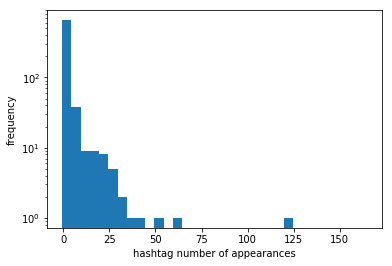

In [23]:
# number of times each hashtag appears
counts = flattened_hashtags_df.groupby(['hashtag']).size()\
                              .reset_index(name='counts')\
                              .counts

# define bins for histogram                              
my_bins = np.arange(0,counts.max()+2, 5)-0.5

# plot histogram of tweet counts
plt.figure()
plt.hist(counts, bins = my_bins)
plt.xlabels = np.arange(1,counts.max()+1, 1)
plt.xlabel('hashtag number of appearances')
plt.ylabel('frequency')
plt.yscale('log', nonposy='clip')
plt.show()

In [24]:
# take hashtags which appear at least this amount of times
min_appearance = 10
# find popular hashtags - make into python set for efficiency
popular_hashtags_set = set(popular_hashtags[
                           popular_hashtags.counts>=min_appearance
                           ]['hashtag'])

In [25]:
# make a new column with only the popular hashtags
hashtags_list_df['popular_hashtags'] = hashtags_list_df.hashtags.apply(
            lambda hashtag_list: [hashtag for hashtag in hashtag_list
                                  if hashtag in popular_hashtags_set])
# drop rows without popular hashtag
popular_hashtags_list_df = hashtags_list_df.loc[
            hashtags_list_df.popular_hashtags.apply(lambda hashtag_list: hashtag_list !=[])]


In [26]:
# make new dataframe
hashtag_vector_df = popular_hashtags_list_df.loc[:, ['popular_hashtags']]

for hashtag in popular_hashtags_set:
    # make columns to encode presence of hashtags
    hashtag_vector_df['{}'.format(hashtag)] = hashtag_vector_df.popular_hashtags.apply(
        lambda hashtag_list: int(hashtag in hashtag_list))

In [27]:
hashtag_vector_df 

,popular_hashtags,#Trump2020,#coronavirus,#Coronvirus,#Agnation,#BestCoverSong,#BestRemix,#BornAliv,#SuperTuesdayResults,#iHea,...,#BamBam,#MORHot10,#BTSArmy,#BestMusicVideo,#SuperTuesday,#EdwardBarber,#KillThisLove,#MakeTrumpNervousIn4Words,#KAG,#BestLyrics
1,[#KCA],0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,[#GOT7],0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23,"[#KillThisLove, #BestMusicVideo, #iHeartAwards]",0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
37,"[#BamBam, #GOT7]",0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
39,[#KillThisLove],0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
57,"[#MORHot10, #MayWard, #MaymayEntrata, #EdwardB...",0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
82,"[#BTSArmy, #BestFanArmy, #iHeartAwards]",0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
86,[#MORHot10],0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
88,"[#BTSArmy, #BestFanArmy, #iHeartAwards]",0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
113,"[#KillThisLove, #FaveChoreography]",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


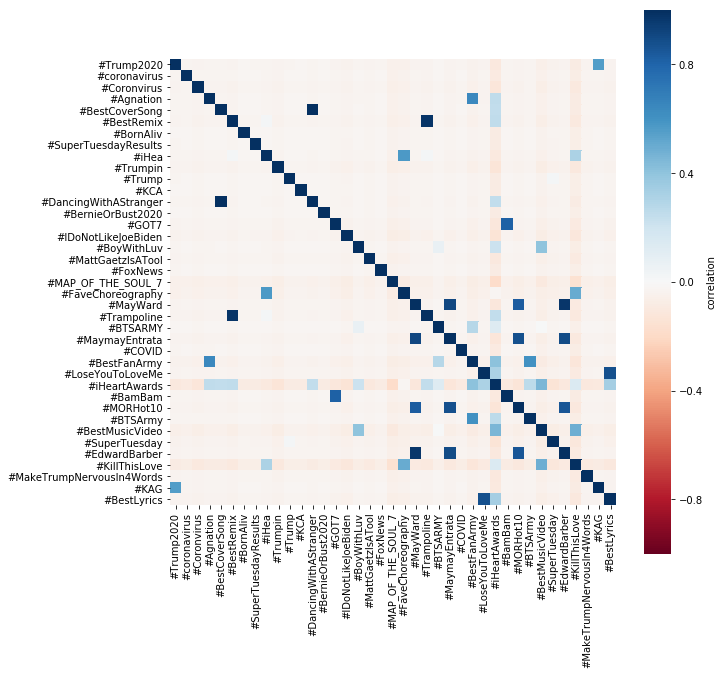

In [28]:
hashtag_matrix = hashtag_vector_df.drop('popular_hashtags', axis=1)
# calculate the correlation matrix
correlations = hashtag_matrix.corr()

# plot the correlation matrix
plt.figure(figsize=(10,10))
sns.heatmap(correlations,
    cmap='RdBu',
    vmin=-1,
    vmax=1,
    square = True,
    cbar_kws={'label':'correlation'})
plt.show()

In [29]:
def remove_links(tweet):
    '''Takes a string and removes web links from it'''
    tweet = re.sub(r'http\S+', '', tweet) # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet) # rempve bitly links
    tweet = tweet.strip('[link]') # remove [links]
    return tweet

def remove_users(tweet):
    '''Takes a string and removes retweet and @user information'''
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove retweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove tweeted at
    return tweet

In [30]:
my_stopwords = nltk.corpus.stopwords.words('english')
word_rooter = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'

# cleaning master function
def clean_tweet(tweet, bigrams=False):
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = tweet.lower() # lower case
    tweet = re.sub('['+my_punctuation + ']+', ' ', tweet) # strip punctuation
    tweet = re.sub('\s+', ' ', tweet) #remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet) # remove numbers
    tweet_token_list = [word for word in tweet.split(' ')
                            if word not in my_stopwords] # remove stopwords

    tweet_token_list = [word_rooter(word) if '#' not in word else word
                        for word in tweet_token_list] # apply word rooter
    if bigrams:
        tweet_token_list = tweet_token_list+[tweet_token_list[i]+'_'+tweet_token_list[i+1]
                                            for i in range(len(tweet_token_list)-1)]
    tweet = ' '.join(tweet_token_list)
    return tweet

In [31]:
df['clean_tweet'] = df.tweet.apply(clean_tweet)

In [32]:
df.head()

,Unnamed: 0,tweet,is_retweet,retweeted,mentioned,hashtags,clean_tweet
0,0,RT @steve_vladeck: There’s no excuse for how h...,True,[@steve_vladeck],[],[],there’ excus hard vote there’ even less excus...
1,1,RT @karan1976U: W..Vote harder\n#KCA\n#VoteTay...,True,[@karan1976U],[],"[#KCA, #VoteTaylorSwiftArtist]",w vote harder #kca #votetaylorswiftartist
2,2,RT @JulieSmithM: I don’t want to hear anything...,True,[@JulieSmithM],[],[],don’t want hear anyth young voter didn’t show...
3,3,RT @Holly_WV: ‼️LMAO‼️\nIf you haven’t seen th...,True,[@Holly_WV],[],[],‼️lmao‼️ haven’t seen you’v got give go guy w...
4,4,RT @nhannahjones: Forcing people to wait in li...,True,[@nhannahjones],[],[],forc peopl wait line hour vote essenti impos...


In [33]:
# Get the important users from the tweets
imp_users_df = df.loc[
                       df.retweeted.apply(
                           lambda imp_user_list: imp_user_list !=[]
                       ),['retweeted']]

In [34]:
# create dataframe where each use of users gets its own row
flattened_users_df = pd.DataFrame(
    [user for users_list in imp_users_df.retweeted
    for user in users_list],
    columns=['retweeted'])

In [35]:
popular_users = flattened_users_df.groupby('retweeted').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)
print("Important 10 users are as follows (whose tweets are highly popular/important)")
popular_users[0:10]

Important 10 users are as follows (whose tweets are highly popular/important)


,retweeted,counts
0,@realDonaldTrump,316
1,@traceyecorder,174
2,@WhiteHouse,155
3,@MsJuneDiane,115
4,@ScottTParkinson,110
5,@soledadobrien,102
6,@LacyJohnsonMN,96
7,@Jim_Jordan,96
8,@Susan_Hennessey,90
9,@AndrewDesiderio,85


In [36]:
# Topic Modeliing and Grouping the words

from sklearn.feature_extraction.text import CountVectorizer

# the vectorizer object will be used to transform text to vector form
vectorizer = CountVectorizer(max_df=0.9, min_df=25, token_pattern='\w+|\$[\d\.]+|\S+')

# apply transformation
tf = vectorizer.fit_transform(df['clean_tweet']).toarray()

# tf_feature_names tells us what word each column in the matric represents
tf_feature_names = vectorizer.get_feature_names()

In [37]:

number_of_topics = 10

model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)

In [38]:
model.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [39]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

In [40]:
no_top_words = 10
display_topics(model, tf_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights,Topic 7 words,Topic 7 weights,Topic 8 words,Topic 8 weights,Topic 9 words,Topic 9 weights
0,super,703.8,…,612.1,vote,2028.4,…,719.0,presid,1096.2,…,1878.8,…,1180.1,…,1009.5,…,709.8,…,688.9
1,tuesday,684.5,schumer,526.3,…,1113.3,presid,494.5,…,643.7,vote,1137.4,presid,686.4,presid,379.9,presid,403.3,presid,289.7
2,…,629.9,court,425.6,i,484.6,’t,225.6,’,551.4,biden,848.3,trump,388.8,’,275.2,need,299.7,trump,285.1
3,sander,390.6,threat,416.2,right,350.9,like,202.5,vote,459.5,berni,445.3,vote,305.1,schumer,232.6,vote,199.3,first,240.8
4,berni,361.2,would,413.4,say,331.3,’,200.9,’t,349.1,like,434.1,thank,215.9,elect,188.3,trump,173.9,justic,200.3
5,get,307.9,suprem,395.1,’m,314.9,he,183.2,trump,312.7,tell,411.8,would,137.1,offic,161.1,old,138.1,vote,192.6
6,win,290.7,amp,343.2,biden,312.0,say,168.3,it,257.6,democrat,396.0,rememb,124.1,threaten,160.5,endors,124.3,realli,190.3
7,vote,254.8,republican,332.0,berni,283.7,media,167.5,stop,256.2,joe,385.7,peopl,121.1,warren,157.2,’,118.5,take,183.1
8,’t,198.6,u,303.9,wait,283.1,biden,161.3,woman,232.1,go,309.5,pleas,119.7,public,157.1,th,114.3,today,160.9
9,biden,180.6,danger,294.8,hour,255.4,new,153.4,don,213.4,peopl,297.2,want,116.3,trump,149.1,warren,111.7,robert,154.0


In [41]:
# vectorize = TfidfVectorizer(stop_words="english")
# vectorize.fit(tweets_txt)
# features = vectorize.transform(tweets_txt)
# random_state=0

# cls = MiniBatchKMeans(n_clusters=5, random_state=random_state)
# cls.fit(features)
# cls.predict(features)

# pca = PCA(n_components=3, random_state=random_state)
# reduced_features = pca.fit_transform(features.toarray())

# # reduce the cluster centers to 2D
# reduced_cluster_centers = pca.transform(cls.cluster_centers_)

# plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(features))
# plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')

# from sklearn.metrics import silhouette_score

# silhouette_score(features, labels=cls.predict(features))